# Preprocessing

## Display images and FFT

In [1]:
import os
import re
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
image_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well2_200locations'
mask_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/masks'

In [3]:
sample_number = 11

# Validate the sample number (1-200)
if not (1 <= sample_number <= 200):
    raise ValueError("Sample number must be between 1 and 200.")

# Format the sample number as a three-digit string (e.g., 8 becomes '008')
sample_str = f"s{str(sample_number).zfill(3)}"

In [4]:
image_filenames = [f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z{str(i).zfill(2)}c2_ORG.tif" for i in range(1, 12)]
mask_filename = f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z06c1_ORG_mask.tiff"
print(image_filenames)

['Alexa488_Fibroblasts_well2_200locations_s011z01c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z02c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z03c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z04c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z05c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z06c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z07c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z08c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z09c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z10c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z11c2_ORG.tif']


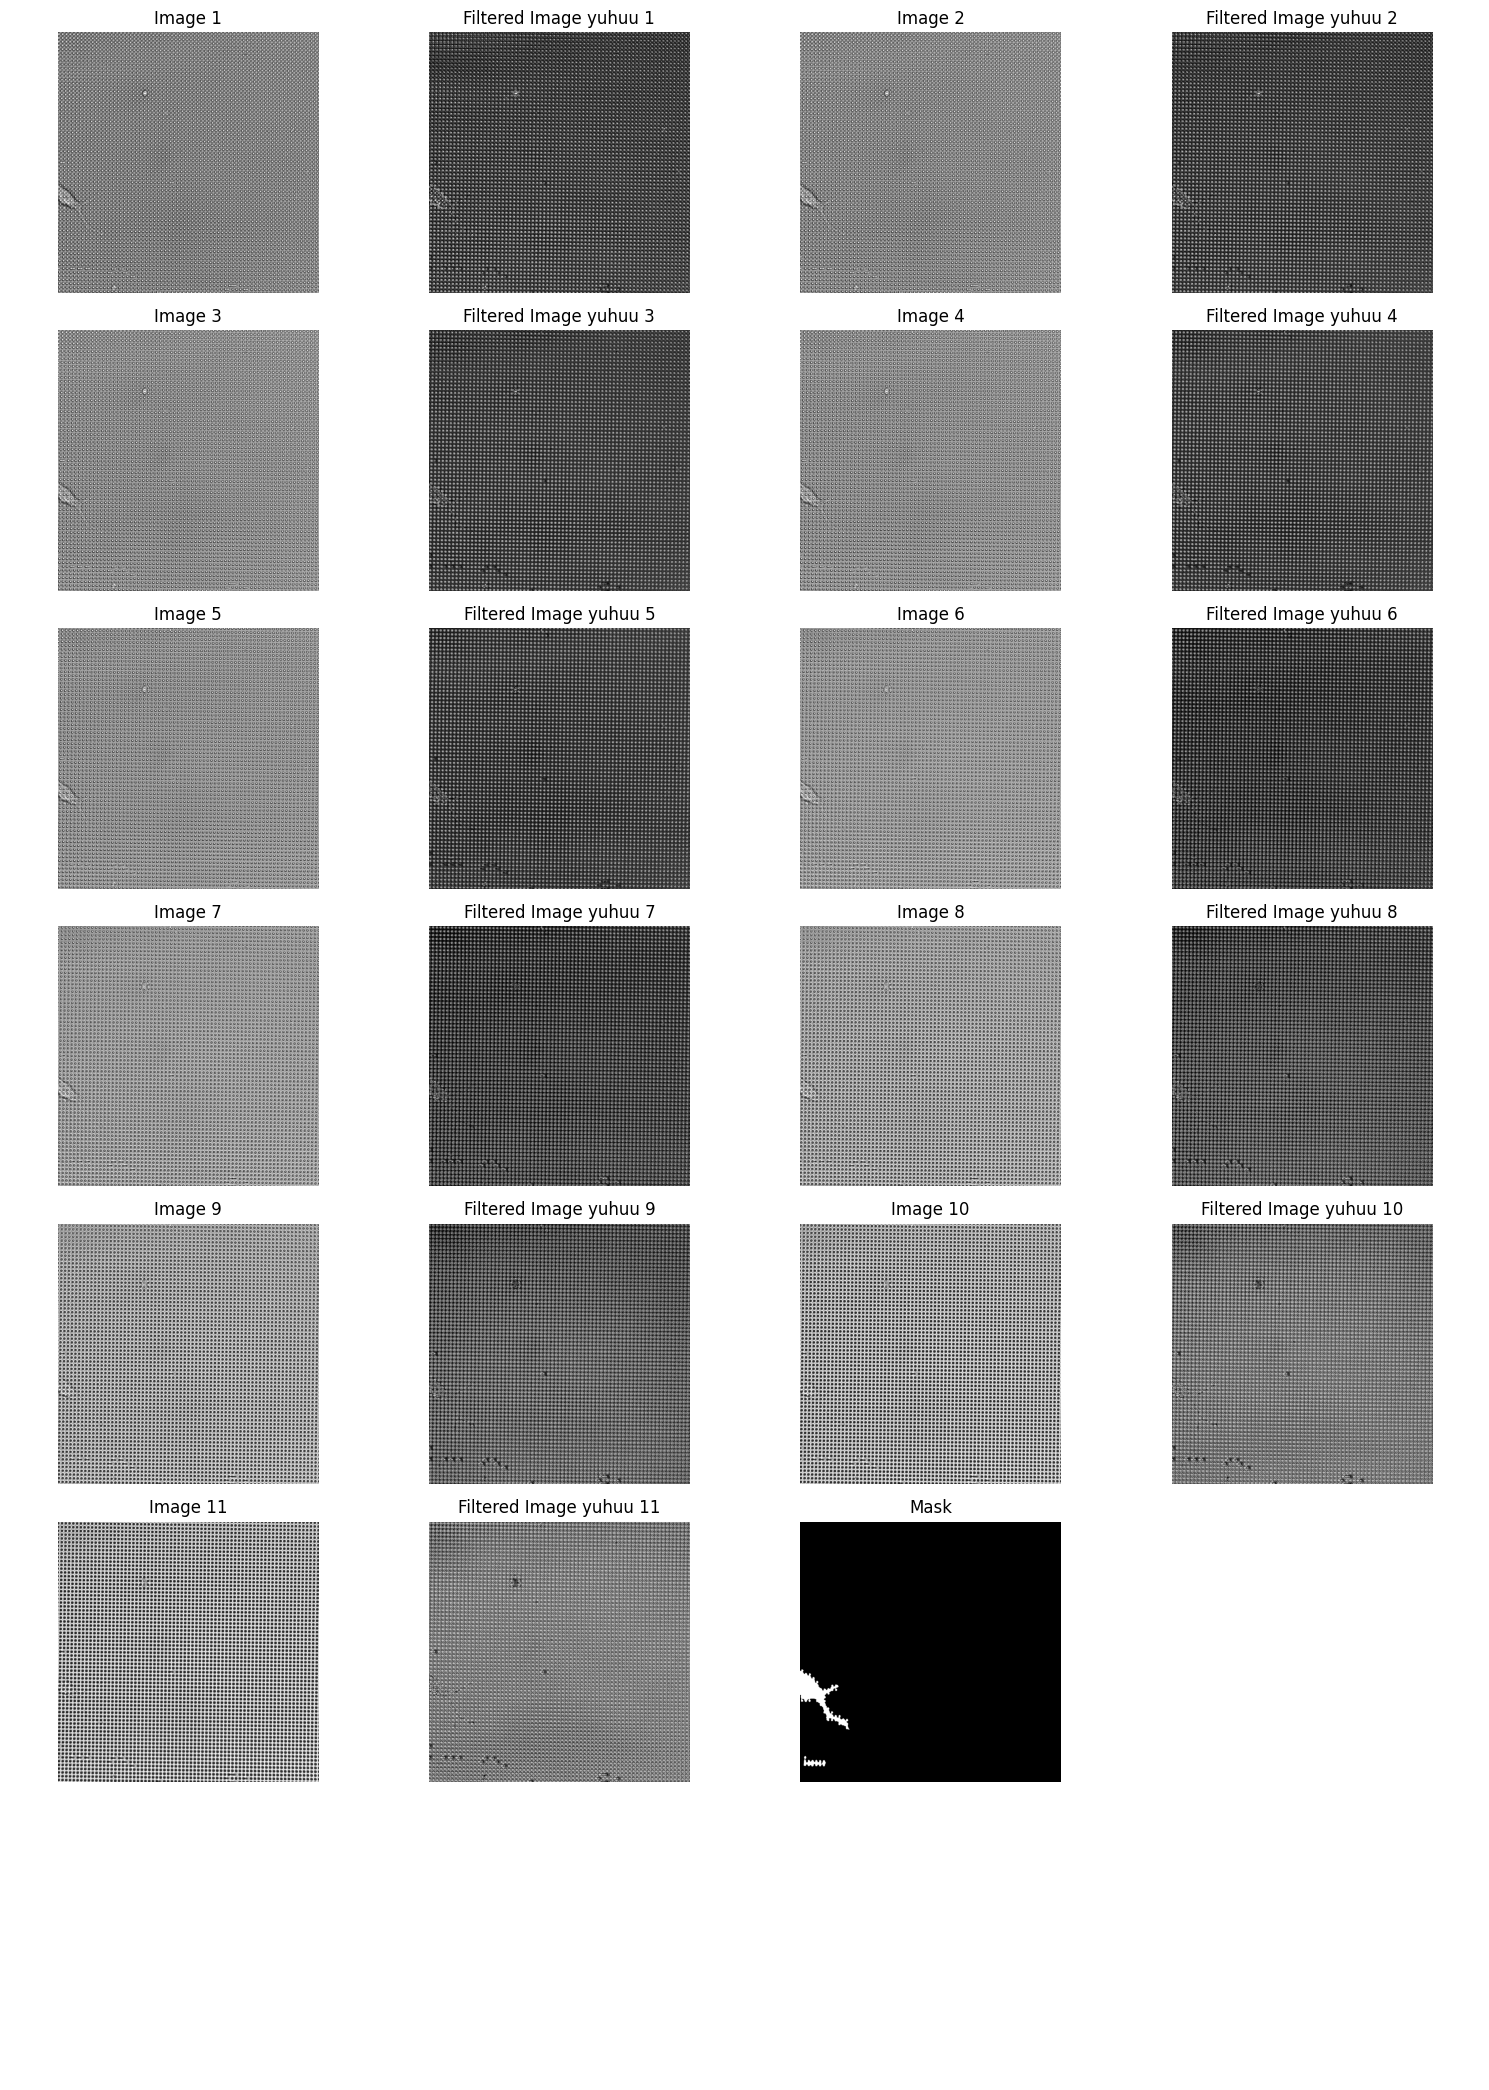

In [5]:
image_filenames = [f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z{str(i).zfill(2)}c2_ORG.tif" for i in range(1, 12)]
mask_filename = f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z06c1_ORG_mask.tiff"

# Filter for files in the directory that match the image filenames
image_files = [f for f in os.listdir(image_dir) if f in image_filenames]

magnitude = False

if len(image_files) == 0:
    print(f"No matching images found for sample {sample_str} in the specified directory.")
elif not os.path.exists(os.path.join(mask_dir, mask_filename)):
    print(f"No matching mask found for sample {sample_str} in the specified mask directory.")
elif magnitude == True:
    images_per_row = 4
    n_images = len(image_files) + 1  # Include the mask as one of the images
    n_rows = max(1, 2 * (n_images + images_per_row - 1) // images_per_row)  # Double rows for original + Spectrum
    image_files = sorted(image_files)  # Sort the images to maintain the order from z01 to z11
    
    fig, axes = plt.subplots(n_rows, images_per_row, figsize=(15, n_rows * 3))
    axes = axes.flatten()

    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(image_dir, image_file)
        img = Image.open(img_path).convert("L")  # Convert to grayscale if needed
        
        # Display the original image
        axes[2 * idx].imshow(img, cmap="gray")
        axes[2 * idx].axis('off')
        axes[2 * idx].set_title(f"Image {idx + 1}")

        # Compute FFT and shift the zero-frequency component to the center
        img_array = np.array(img)
        fft_img = np.fft.fft2(img_array)
        fft_shifted = np.fft.fftshift(fft_img)

        # Compute magnitude spectrum and use logarithmic scale for better visibility
        magnitude_spectrum = np.log(np.abs(fft_shifted) + 1)  # Add 1 to avoid log(0)

        # Display the magnitude spectrum
        axes[2 * idx + 1].imshow(magnitude_spectrum, cmap="gray")
        axes[2 * idx + 1].axis('off')
        axes[2 * idx + 1].set_title(f"Magnitude Spectrum {idx + 1}")

    plt.show()
else:
    images_per_row = 4
    n_images = len(image_files) + 1  # Include the mask as one of the images
    n_rows = max(1, 2 * (n_images + images_per_row - 1) // images_per_row)  # Double rows for original + Filtered FFT
    image_files = sorted(image_files)  # Sort the images to maintain the order from z01 to z11
    
    fig, axes = plt.subplots(n_rows, images_per_row, figsize=(15, n_rows * 3))
    axes = axes.flatten()

    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(image_dir, image_file)
        img = Image.open(img_path).convert("L")  # Convert to grayscale if needed
        
        # Display the original image
        axes[2 * idx].imshow(img, cmap="gray")
        axes[2 * idx].axis('off')
        axes[2 * idx].set_title(f"Image {idx + 1}")

        # Compute and apply FFT filtering
        img_array = np.array(img)
        fft_img = np.fft.fft2(img_array)
        fft_shifted = np.fft.fftshift(fft_img)

        # Define parameters for band-stop filter
        radius = 0.001  # Adjust as needed based on the nanopillar pattern
        stop_band_width = 0.01  # Width of the band-stop area

        # Create a band-stop filter mask
        rows, cols = img_array.shape
        crow, ccol = rows // 2, cols // 2  # Center of the frequency domain

        # Initialize the mask with ones (keep all frequencies initially)
        mask = np.ones((rows, cols), dtype=np.float32)
        for x in range(rows):
            for y in range(cols):
                dist = np.sqrt((x - crow)**2 + (y - ccol)**2)
                if radius - stop_band_width < dist < radius + stop_band_width:
                    mask[x, y] = 0  # Block frequencies within the band-stop range

        # Apply the mask to the shifted FFT image
        fft_filtered = fft_shifted * mask

        # Compute the inverse FFT to obtain the filtered image
        ifft_shifted = np.fft.ifftshift(fft_filtered)
        filtered_img = np.fft.ifft2(ifft_shifted)
        filtered_img = np.abs(filtered_img)  # Take magnitude for display

        # Display the filtered image (inverse FFT result)
        axes[2 * idx + 1].imshow(filtered_img, cmap="gray")
        axes[2 * idx + 1].axis('off')
        axes[2 * idx + 1].set_title(f"Filtered Image yuhuu {idx + 1}")

    # Display the mask in the last row
    mask_path = os.path.join(mask_dir, mask_filename)
    mask_img = Image.open(mask_path)
    axes[2 * len(image_files)].imshow(mask_img, cmap="gray")
    axes[2 * len(image_files)].axis('off')
    axes[2 * len(image_files)].set_title("Mask")

    # Hide any remaining empty subplots
    for j in range(2 * len(image_files) + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Experiment 1: Simple Segmentation Model

## Dataloading

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
from pathlib import Path
from dataloader import get_dataloader, walk_through_dir

In [2]:
data_path = "/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/"
walk_through_dir(Path(data_path))

There are 2 directories and 2 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data'.
There are 7 directories and 0 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well5_225locations'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well4_225locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well6_135locations'.
There are 0 directories and 2156 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well3_200locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well7_

In [3]:
image_dirs = [data_path + 'brightfield/Alexa488_Fibroblasts_well1_50locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well2_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well3_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well4_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well5_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well6_135locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well7_135locations']
mask_dir = data_path + 'masks'

In [4]:
def set_seed(seed=111):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
    random.seed(seed)
    np.random.seed(seed)

Number of images in the trainset: 1112
Number of images in the testset: 50
First image from trainset:


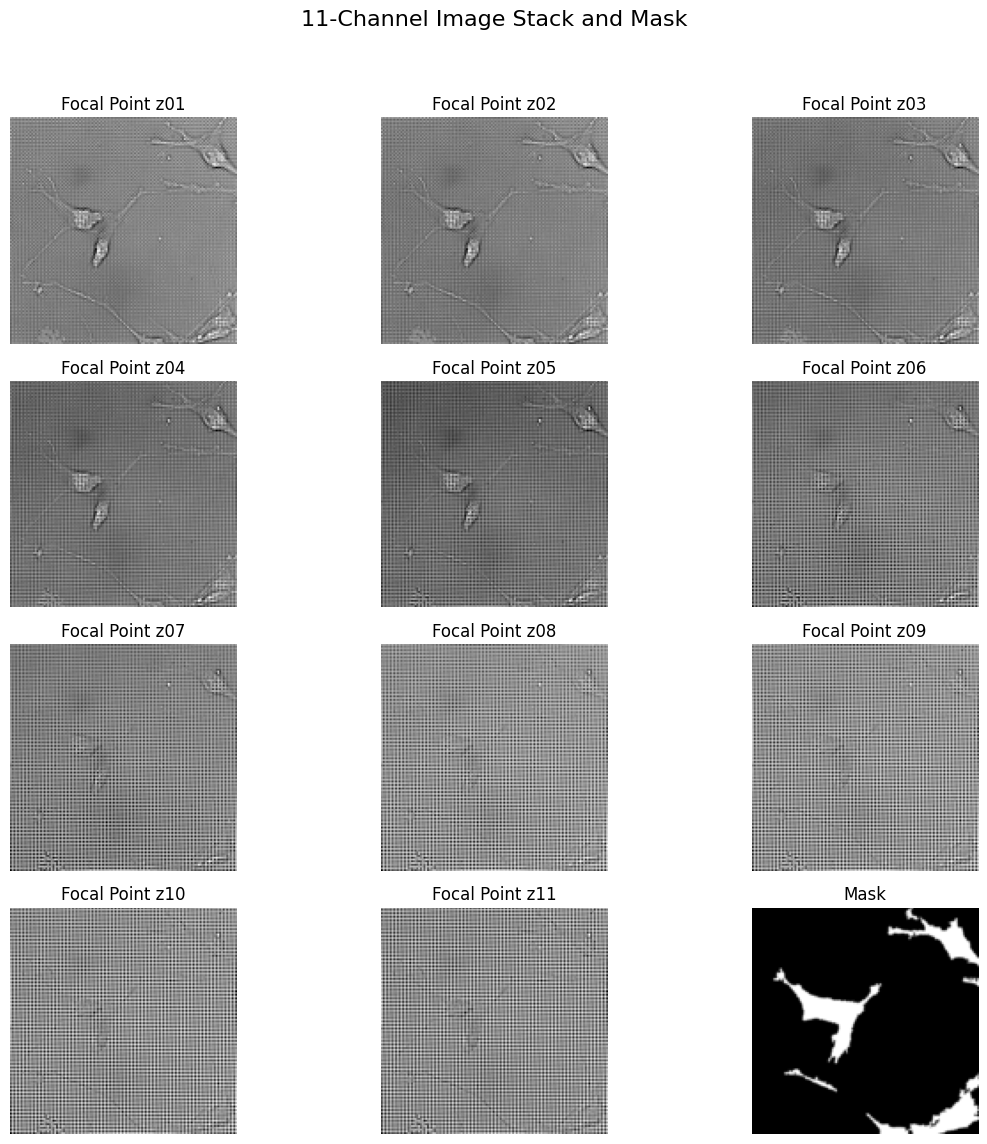

First image from testset:


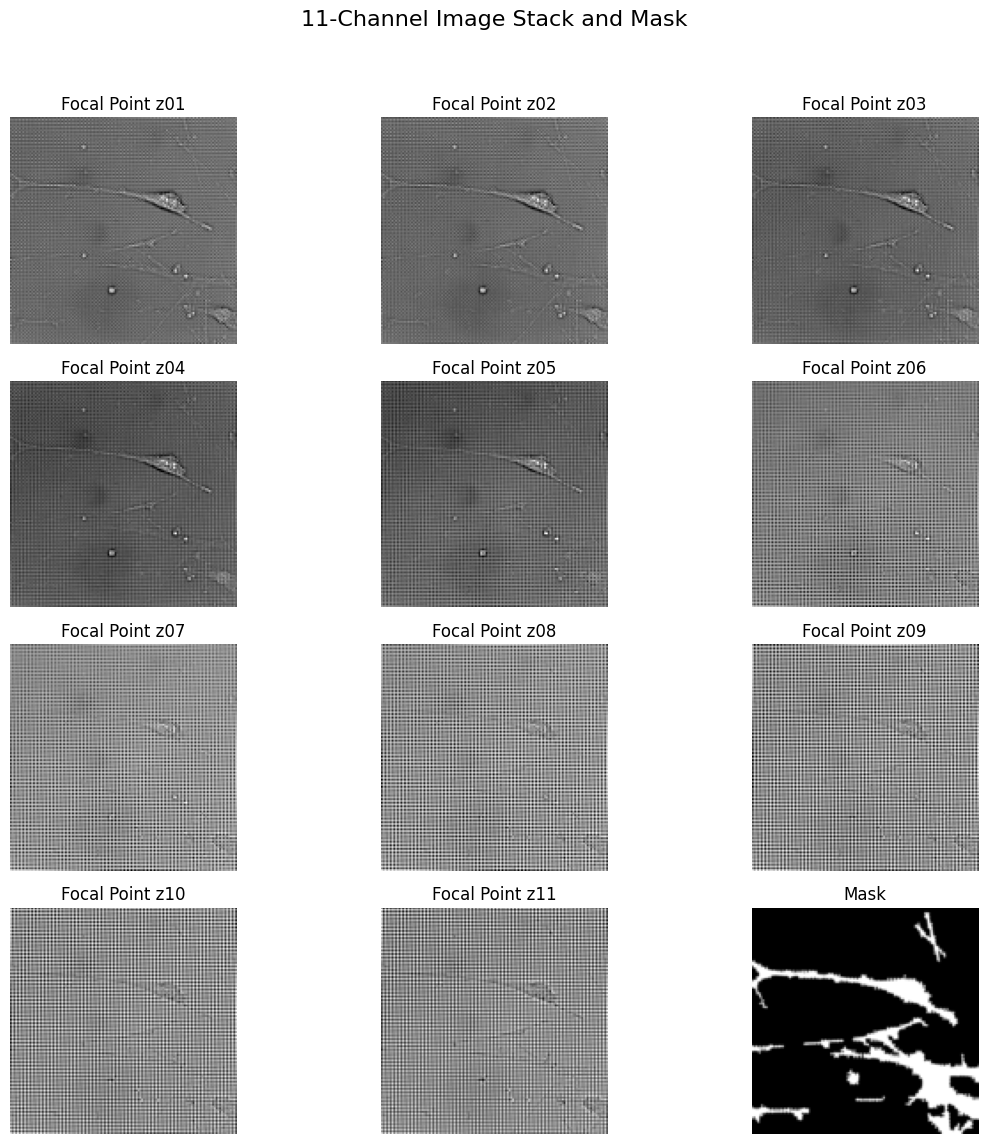

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
mask_transform = data_transform

train_dataloader, test_dataloader = get_dataloader(image_dirs, mask_dir, data_transform, mask_transform, display_sample=True)

## Models definition

In [6]:
class SimpleSegmentationModel(nn.Module):
    def __init__(self):
        super(SimpleSegmentationModel, self).__init__()
        
        # Downsampling (Encoder)
        self.conv1 = nn.Conv2d(11, 32, kernel_size=3, padding=1)  # Input channels: 11
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Upsampling (Decoder)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)  # Output channels: 1 for binary mask
        
    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Downsample by factor of 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Downsample by factor of 2
        
        # Decoder
        x = F.relu(self.upconv1(x))
        x = torch.sigmoid(self.upconv2(x))  # Sigmoid to keep output in range [0, 1]
        
        return x

In [7]:
# improvements: batch normalization, dropout for regularization, and skip connections for better spatial feature retention
class SegmentationModel(nn.Module):
    def __init__(self):  # Correctly use __init__ here
        super(SegmentationModel, self).__init__()  # Correctly use __init__ here
        
        # Encoder: Downsampling Path
        self.enc1 = self._conv_block(11, 64)    # Input channels: 11 (BF images)
        self.enc2 = self._conv_block(64, 128)
        self.enc3 = self._conv_block(128, 256)
        
        # Bottleneck
        self.bottleneck = self._conv_block(256, 512)
        
        # Decoder: Upsampling Path
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._conv_block(512, 256)  # Skip connection from enc3
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(256, 128)  # Skip connection from enc2
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(128, 64)   # Skip connection from enc1
        
        # Output Layer
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)  # Output channels: 1 for binary mask
    
    def _conv_block(self, in_channels, out_channels):
        """
        A helper function to create a convolutional block with Conv2d, BatchNorm, and ReLU.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        x = F.max_pool2d(enc1, 2)  # Downsample by factor of 2
        
        enc2 = self.enc2(x)
        x = F.max_pool2d(enc2, 2)
        
        enc3 = self.enc3(x)
        x = F.max_pool2d(enc3, 2)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder
        x = self.upconv3(x)
        x = torch.cat((x, enc3), dim=1)  # Concatenate with skip connection
        x = self.dec3(x)
        
        x = self.upconv2(x)
        x = torch.cat((x, enc2), dim=1)
        x = self.dec2(x)
        
        x = self.upconv1(x)
        x = torch.cat((x, enc1), dim=1)
        x = self.dec1(x)
        
        # Output Layer
        x = torch.sigmoid(self.out_conv(x))  # Sigmoid for binary mask
        
        return x

In [8]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(11, 64)  # 11 channels to 64
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)  # 1024 from skip + upconv
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)  # 512 from skip + upconv
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)  # 256 from skip + upconv
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)  # 128 from skip + upconv
        
        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)  # Single output channel (binary mask)
        
    def conv_block(self, in_channels, out_channels):
        """Convolutional block: Conv2d -> ReLU -> Conv2d -> ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        # Decoder with skip connections
        up4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat((up4, enc4), dim=1))  # Skip connection
        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))  # Skip connection
        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))  # Skip connection
        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))  # Skip connection
        
        # Final output
        return torch.sigmoid(self.final(dec1))  # Output in range [0, 1]

## Training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

set_seed()

# Initialize model, loss function, and optimizer
model_name = "Estel"
if model_name == "Simple":
    model = SimpleSegmentationModel().to(device)
elif model_name == "Estel":
    model = SegmentationModel().to(device)
elif model_name == "UNet":
    model = UNet().to(device)
    
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [ ]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        start_time = time.time()  # Record the start time of the epoch

        for images, masks in train_loader:
            # Move images and masks to the device (GPU if available)
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate the loss for this batch
            epoch_loss += loss.item()

        # Calculate epoch duration
        epoch_duration = time.time() - start_time

        # Average loss for this epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Time: {epoch_duration:.2f} seconds")

# Train the model with the training dataloader
train_model(model, train_dataloader, criterion, optimizer, num_epochs=15)

## Evaluation

In [16]:
current_directory = os.getcwd()
model_save_path = os.path.join(current_directory, "segmentation_model.pth")

# Load the model
model_name = "Estel"
if model_name == "Simple":
    model = SimpleSegmentationModel().to(device)
elif model_name == "Estel":
    model = SegmentationModel().to(device)
elif model_name == "UNet":
    model = UNet().to(device)

model.load_state_dict(torch.load(model_save_path))
print("Model loaded successfully.")

Model loaded successfully.


torch.Size([1, 128, 128])


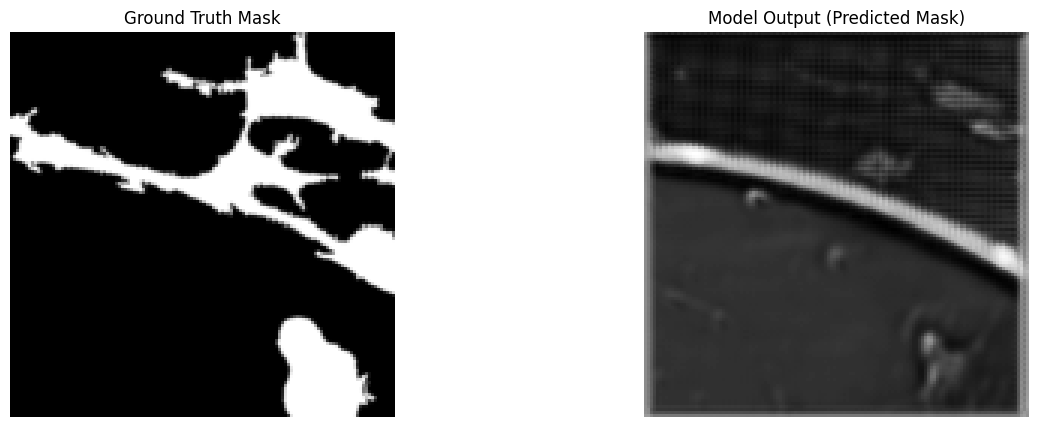

In [27]:
# Sample evaluation
batch = next(iter(test_dataloader))  # Get one batch
images, masks = batch
random_idx = random.randint(0, images.size(0) - 1)  # Random index within batch size
random_images = images.to(device)
random_mask = masks[random_idx].to(device) # Select only one random sample to plot

model.eval()

with torch.no_grad():  # No gradient computation needed for inference
    output = model(random_images)[random_idx]  # Forward pass and select only random sample to plot

print(output.shape)
binary_output = (output > 0.5).float() # Make binary segmentation

# Plot the input image, ground truth mask, and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(random_mask.cpu().squeeze().numpy(), cmap="gray")
axes[0].axis("off")
axes[0].set_title("Ground Truth Mask")

axes[1].imshow(output.cpu().squeeze().numpy(), cmap="gray") # Change to binary_output if want to display binary mask
axes[1].axis("off")
axes[1].set_title("Model Output (Predicted Mask)")

plt.show()

In [25]:
# Evaluate the model
def evaluate_model(model, test_dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient computation
        for images, masks in test_dataloader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_dataloader)
    print(f"Average Loss on Test Set: {avg_loss:.4f}")

# Call the evaluation function
evaluate_model(model, test_dataloader, criterion)

Average Loss on Test Set: 0.4496


# ↓ _Here below not used for the moment_ ↓

# MANUAL U-NET

U-Net is well-suited for this problem due to its skip connections, which preserve spatial details

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(11, 64)  # 11 channels to 64
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)  # 1024 from skip + upconv
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)  # 512 from skip + upconv
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)  # 256 from skip + upconv
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)  # 128 from skip + upconv
        
        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)  # Single output channel (binary mask)
        
    def conv_block(self, in_channels, out_channels):
        """Convolutional block: Conv2d -> ReLU -> Conv2d -> ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        # Decoder with skip connections
        up4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat((up4, enc4), dim=1))  # Skip connection
        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))  # Skip connection
        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))  # Skip connection
        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))  # Skip connection
        
        # Final output
        return torch.sigmoid(self.final(dec1))  # Output in range [0, 1]


In [ ]:
import torch

# Assume the U-Net class is already defined
# Initialize the U-Net model
model = UNet().to(device)  # Use the manual U-Net implementation
model.eval()  # Set to evaluation mode

# Create a fake input tensor
batch_size = 1  # Simulate one image in the batch
input_channels = 11  # Corresponds to the 11 focal planes
height, width = 128, 128  # Image dimensions

# Generate a fake tensor with random values
fake_input = torch.rand(batch_size, input_channels, height, width).to(device)

# Pass the fake data through the model
with torch.no_grad():  # Disable gradient computation for testing
    output = model(fake_input)

# Print the output shape
print(f"Input shape: {fake_input.shape}")
print(f"Output shape: {output.shape}")

# Verify output dimensions
assert output.shape == (batch_size, 1, height, width), "Output dimensions are incorrect!"

# Optionally, visualize the output (single channel binary mask)
import matplotlib.pyplot as plt

# Move output to CPU and remove batch dimension
output_image = output.squeeze(0).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Plot the output
plt.figure(figsize=(5, 5))
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.title("Fake Output")
plt.show()

# PRETRAINED U-NET

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn

# Load pretrained U-Net with a ResNet backbone
pretrained_unet = smp.Unet(
    encoder_name="resnet34",        # Choose a ResNet backbone (others available)
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Placeholder for in_channels, will replace later
    classes=1                      # Output channels (binary mask)
)

# Modify the first convolutional layer to accept 11 input channels
pretrained_unet.encoder.conv1 = nn.Conv2d(
    in_channels=11,               # From 3 to 11 channels
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

# Optional: Initialize weights for the modified layer
nn.init.kaiming_normal_(pretrained_unet.encoder.conv1.weight, mode='fan_out', nonlinearity='relu')

# Move to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_unet = pretrained_unet.to(device)
